# Binary Prediction of Poisonous Mushrooms

In this notebook, we're going to go through an example machine learning project with the goal of predicting wether the mushroom is poisonous or edible .

## 1. Problem defition

> How well can we predict the mushroom is poisonous or edible, given its physical characteristics 

## 2. Data

The data is downloaded from the Kaggle Binary Prediction of Poisonous Mushrooms competition: https://www.kaggle.com/competitions/playground-series-s4e8/

There are 3 main datasets:

* train.csv - the training dataset; class is the binary target (either e or p)
* test.csv - the test dataset; your objective is to predict target class for each row
* sample_submission.csv - a sample submission file in the correct format.

## 3. Evaluation

The evaluation metric for this competition is the `Matthews correlation coefficient (MCC)`.


In [58]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna



import warnings
warnings.filterwarnings('ignore')

In [32]:
# Import training and validation sets
df_train = pd.read_csv("data/train.csv",
                 low_memory=False)
df_test = pd.read_csv("data/test.csv",
                 low_memory=False)

df_train.shape,df_test.shape

((3116945, 22), (2077964, 21))

In [33]:
df_train.head()


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [35]:
df_train.isna().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [36]:
df_test.isna().sum()

id                            0
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                   1
stem-width                    0
stem-root               1838012
stem-surface            1321488
stem-color                   21
veil-type               1971545
veil-color              1826124
has-ring                     19
ring-type                 86195
spore-print-color       1899617
habitat                      25
season                        0
dtype: int64

In [37]:
# Define different categorical features 
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove("class")

for col in categorical_features:
    mode_value = df_train[col].mode()[0]
    df_train[col].fillna(mode_value, inplace=True)
    
for col in categorical_features:
    mode_value = df_test[col].mode()[0]
    df_test[col].fillna(mode_value, inplace=True)

In [38]:
df_train.drop_duplicates()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,b,s,w,u,w,f,f,k,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,b,y,o,u,w,t,z,k,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,b,s,n,u,w,f,f,k,l,w
3,3,e,3.88,f,y,g,f,s,c,g,...,b,s,w,u,w,f,f,k,d,u
4,4,e,5.85,x,l,w,f,d,c,w,...,b,s,w,u,w,f,f,k,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,3116940,e,9.29,f,t,n,t,a,c,w,...,b,s,w,u,w,t,g,k,d,u
3116941,3116941,e,10.88,s,t,w,t,d,c,p,...,b,s,w,u,w,f,f,k,d,u
3116942,3116942,p,7.82,x,e,e,f,a,c,w,...,b,s,y,u,w,t,z,k,d,a
3116943,3116943,e,9.45,p,i,n,t,e,c,p,...,b,y,w,u,w,t,p,k,d,u


In [40]:
# encoding catagorical features to numbers and handling missing vals
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_train[categorical_features]=enc.fit_transform(df_train[categorical_features])
df_test[categorical_features]=enc.transform(df_test[categorical_features])



In [41]:
# labelin the class 
label=LabelEncoder()
df_train["class"]=label.fit_transform(df_train["class"])

In [42]:
df_train.head().T

,0,1,2,3,4
id,0.00,1.00,2.00,3.00,4.00
class,0.00,1.00,0.00,0.00,0.00
cap-diameter,8.80,4.51,6.94,3.88,5.85
cap-shape,53.00,71.00,53.00,53.00,71.00
cap-surface,72.00,56.00,72.00,81.00,65.00
cap-color,72.00,64.00,49.00,57.00,74.00
does-bruise-or-bleed,8.00,8.00,8.00,8.00,8.00
gill-attachment,44.00,44.00,75.00,70.00,47.00
gill-spacing,28.00,28.00,28.00,28.00,28.00
gill-color,59.00,46.00,59.00,37.00,59.00


In [43]:
df_train=df_train.dropna()
df_train.isna().sum()

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

## Visualizing the data

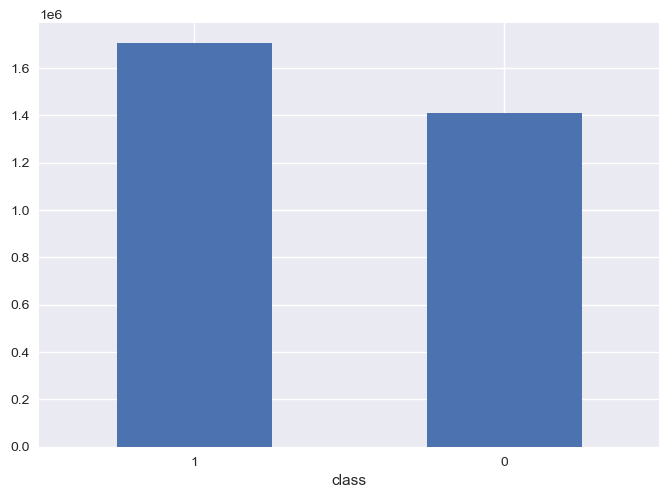

In [44]:
plt.style.use('seaborn-v0_8')
df_train["class"].value_counts().plot(kind="bar")
plt.xticks(rotation=1);

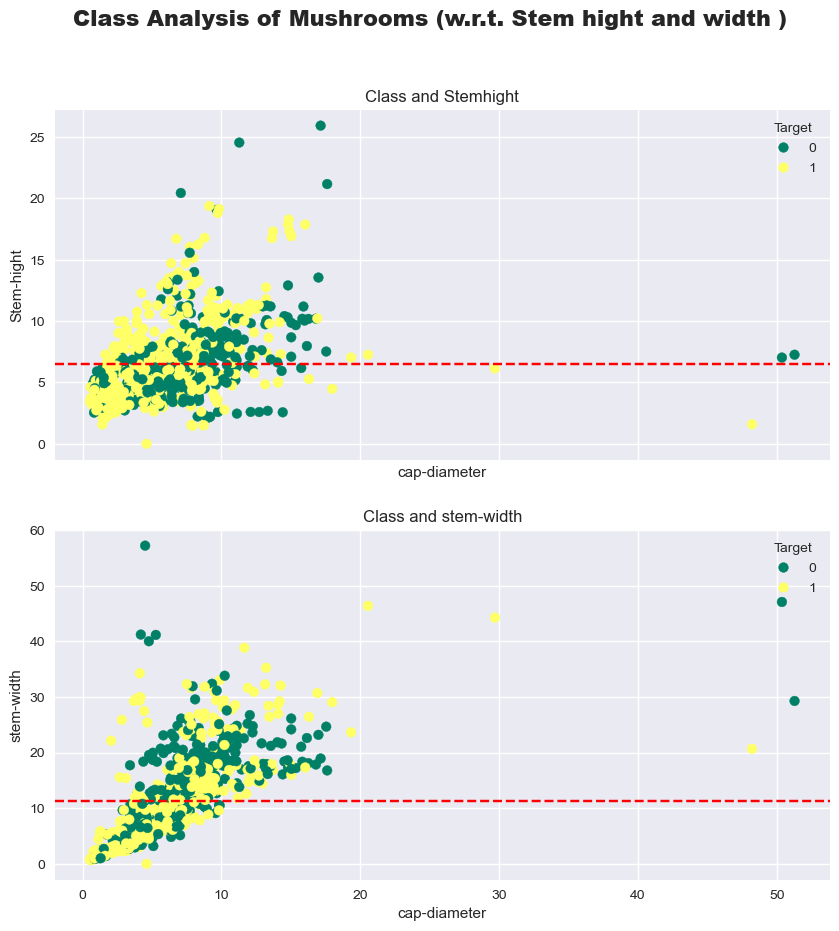

In [45]:

#Creating canves for stemhight,cap-diamter and class
fig, (ax0,ax1)=plt.subplots(nrows=2,
                           ncols=1,
                           figsize=(10,10),
                           sharex=True)
#Adding data to ax0
scatter = ax0.scatter(x=df_train["cap-diameter"][:1000],
                    y=df_train["stem-height"][:1000],
                    c=df_train["class"][:1000],
                    cmap="summer"
                   )

#customisng ax0
ax0.set(title="Class and Stemhight",
       ylabel="Stem-hight",
       xlabel="cap-diameter"
    
);
ax0.legend(*scatter.legend_elements(),title="Target")

#adding horizontal line to ax0

ax0.axhline(df_train["stem-height"][:1000].mean(),
          linestyle="--",
          color="r");

# Cap-diamter and stem root
#adding data
scatter=ax1.scatter(x=df_train["cap-diameter"][:1000],
                    y=df_train["stem-width"][:1000],
                    c=df_train["class"][:1000],
                    cmap="summer")
#Customisng plot
ax1.set(title="Class and stem-width",
       ylabel="stem-width",
       xlabel="cap-diameter"
    
);
ax1.legend(*scatter.legend_elements(),title="Target")

#horizonal line
ax1.axhline(df_train["stem-width"][:1000].mean(),
          linestyle="--",
          color="r");


fig.suptitle("Class Analysis of Mushrooms (w.r.t. Stem hight and width )",size=16,weight= 800);

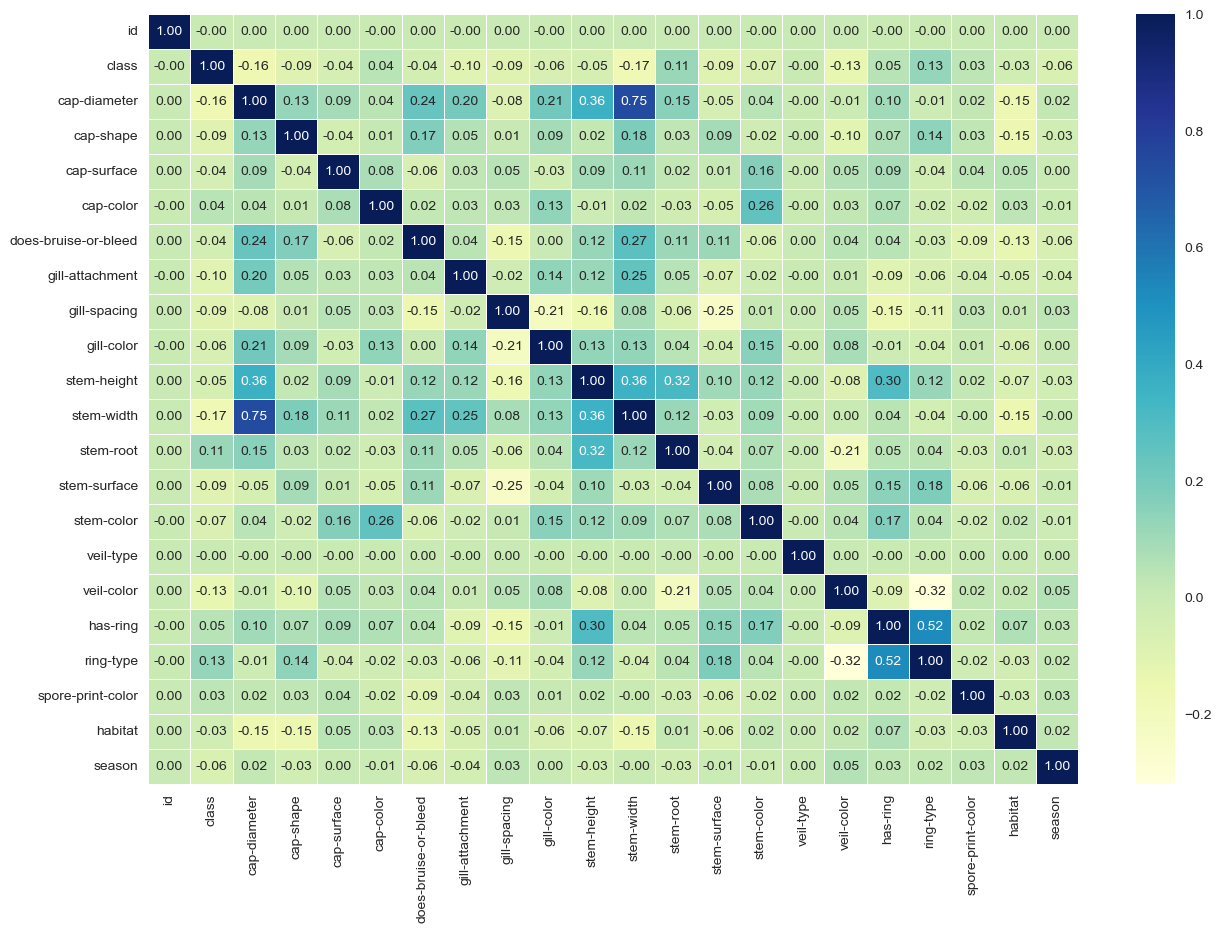

In [46]:
#Co relation metrix
corr_metrics= df_train.corr()
fig, ax= plt.subplots(figsize=(15,10))
ax=sns.heatmap(corr_metrics,
              annot=True,
              linewidths=0.5,
              fmt=".2f",
              cmap="YlGnBu")

## Splitting the data

In [47]:
X=df_train.drop(["class","id"],axis=1)
y=df_train["class"]
test = df_test.drop(['id'], axis=1)
X.shape,y.shape,test.shape

((3116941, 20), (3116941,), (2077964, 20))

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [ ]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2)

In [59]:
# put models into a dictionaty (helps in reuse)
models={
    "RandomForest":RandomForestClassifier(),
    "XG boost":XGBClassifier(),
    "CatBoost": CatBoostClassifier( verbose=0),
    "LGBM":LGBMClassifier(verbose=0)
    
}

def fit_and_score(models,X_train,X_test,y_train,y_test):
    """
    Fits and Evaluate a ML Model using matthews_corrcoef matrix
    models:a dict of models
    X_train: training data
    X_test:testing data
    y_train:testing labels
    y_test:testing labels
    
    """
    np.random.seed(42)
    #Creatinga adict to store the score val
    modelscore={}
    #loop through models
    for name, model in models.items():
        #fitting the model
        model.fit(X_train,y_train)
        #Making Preds
        y_preds=model.predict(X_test)
        #EvaluateModel
        modelscore[name]=matthews_corrcoef(y_test,y_preds)

    return modelscore

        

In [20]:
model_scores=fit_and_score(models,X_train,X_test,y_train,y_test)
model_scores


KeyboardInterrupt



### Model Performance

The performance of various models has been evaluated, and the following accuracy scores were obtained:

- **RandomForest**: 0.9829
- **XGBoost**: 0.9796
- **CatBoost**: 0.9808
- **LGBM**: 0.9734

Based on these results, we will only consider **RandomForest** and **CatBoost**going forward (as they have the highest scores) and we will do thier hyperparameter tuning 



## HyperParameter tuning 

In [63]:
# Creating a dataset one fifth of the total size for hyper parameters tuning to save time
df_temp = df_train[:100000]
df_temp.shape

(100000, 22)

In [64]:
X_temp=df_temp.drop(["class","id"],axis=1)
y_temp=df_temp["class"]
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [67]:
models={
    "RandomForest":RandomForestClassifier(n_jobs=-1,random_state=42)
}
rf_trainingdata= fit_and_score(models,X_train_temp, X_test_temp, y_train_temp, y_test_temp)
rf_trainingdata


{'RandomForest': 0.9789179674474049}

{'RandomForest':0.9789179674474049} trying to find the hyper parameters to get a score greater then this on training temp data

In [105]:
# Using Random Search CV
rf_grid = {
    "n_estimators": np.arange(10, 101, 10),
    "max_depth": [None],
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 10, 2),
    "max_features": ['auto'],
    "max_samples": [None]
}



In [106]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
import numpy as np
import pandas as pd

def random_forest_randomized_search(X_train, y_train, param_distributions, n_iter=100, cv=3, random_state=42, n_jobs=-1):
    """
    Perform RandomizedSearchCV on a RandomForestClassifier.
    
    Parameters:
    - X_train: Training data features.
    - y_train: Training data labels.
    - param_distributions: Dictionary with parameters names (`str`) as keys and distributions or lists of parameters to try.
    - n_iter: Number of parameter settings that are sampled. Defaults to 100.
    - cv: Cross-validation splitting strategy. Defaults to 3-fold.
    - random_state: Seed for the random number generator. Defaults to 42.
    - n_jobs: Number of jobs to run in parallel. Defaults to -1 (use all processors).

    Returns:
    - Best estimator from the randomized search.
    - Best parameters found by the randomized search.
    - Results of the search as a pandas DataFrame.
    """
    np.random.seed(random_state)
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=random_state)
    mcc_scorer = make_scorer(matthews_corrcoef)
    # Initialize RandomizedSearchCV
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=True,
        n_jobs=n_jobs,
        scoring=mcc_scorer,
        random_state=random_state
    )

    # Fit the model
    rf_random_search.fit(X_train, y_train)

    # Best estimator
    best_estimator = rf_random_search.best_estimator_

    # Best parameters
    best_params = rf_random_search.best_params_

    # Results as a DataFrame
    results_df = pd.DataFrame(rf_random_search.cv_results_)

    return best_estimator, best_params, results_df



In [111]:
best_estimator, best_params = random_forest_randomized_search(X_train_temp, y_train_temp, rf_grid)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [87]:
models={
    "RandomForest":best_estimator
}
rf_trainingdata= fit_and_score(models,X_train_temp, X_test_temp, y_train_temp, y_test_temp)
rf_trainingdata


{'RandomForest': 0.9785155256221088}

In [88]:
best_params

{'n_estimators': 39,
 'min_samples_split': 14,
 'min_samples_leaf': 3,
 'max_samples': None,
 'max_features': 'sqrt',
 'max_depth': None}

In [108]:
clf= RandomForestClassifier(n_jobs=-1)
clf.fit(X,y)


RandomForestClassifier(n_jobs=-1)

In [109]:
import pickle

# Assuming `best_model` is your trained model
filename = 'model.pkl'

# Save the model
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

print(f"Model saved to {filename}")

Model saved to model.pkl


In [110]:
filename = 'model.pkl'

# Load the model
with open(filename, 'rb') as file:
   clf = pickle.load(file)

print(f"Model loaded from {filename}")

Model loaded from model.pkl


In [115]:
test_preds=clf.predict(test)

In [116]:
class_mapping = {0: 'e', 1: 'p'}
mapped_preds = [class_mapping[pred] for pred in test_preds]

# Creating the submission file
submission = pd.DataFrame({
    'id': df_test['id'],  # Replace with the actual ID column name
    'class': mapped_preds
})

submission.to_csv('submission3.csv', index=False)